In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal
from IPython.display import clear_output
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'episode {frame_idx} reward: {rewards[-1]:.2f}')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

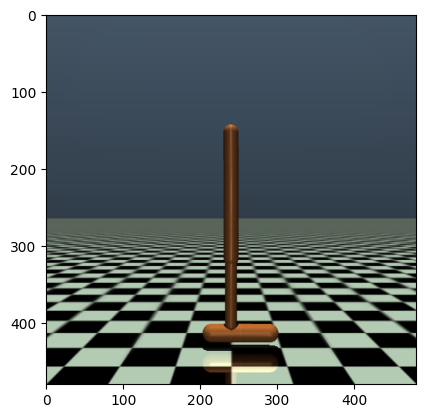

In [4]:
env = gym.make('Hopper-v4',render_mode = 'rgb_array')
env = gym.wrappers.ClipAction(env)
env = gym.wrappers.NormalizeObservation(env)
state,info = env.reset()
plt.imshow(env.render())

In [15]:
class A_C(nn.Module):
    def __init__(self, state_shape):
        super(A_C,self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(state_shape,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,3)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_shape,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.actor_log_std = nn.Parameter(torch.zeros(1,3))
        
    def forward(self,x):
        actor_mu = self.actor(x)
        actor_logstd = self.actor_log_std.expand_as(actor_mu)
        actor_std = torch.exp(actor_logstd)
        pdf = Normal(actor_mu,actor_std)
        value = self.critic(x)
        return pdf,value

In [28]:
NUM_ENVS = 20
OBS_SHAPE = env.observation_space.shape[0]
ACTION_SPACE_SHAPE = env.action_space.shape[0]
GAMMA = 0.99
LAMBDA = 0.95
BATCH_SIZE = 64
NUM_EPOCHS = 20
N_ROLLOUTS = 1000
ROLL_OUT_STEPS = 2048
BUFFER_SIZE = ROLL_OUT_STEPS * NUM_ENVS
ENTROPY_COEF = 0
RESUME = True

In [29]:
Agent = A_C(OBS_SHAPE).to(device)

In [30]:
envs = gym.make_vec('Hopper-v4',NUM_ENVS,wrappers=[gym.wrappers.ClipAction,gym.wrappers.NormalizeObservation,gym.wrappers.NormalizeReward])
states,info = envs.reset()

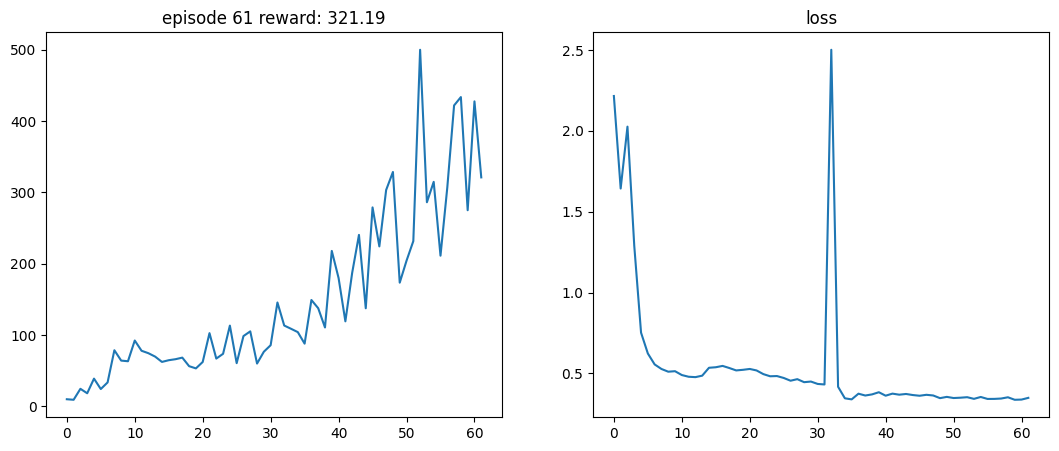

KeyboardInterrupt: 

In [31]:
optimizer = torch.optim.Adam(Agent.parameters(),lr=3e-4,eps=1e-7)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999)
epsilon = 0.2
episode_reward = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
t_rewards = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
log_probs = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
values = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
states = np.zeros([ROLL_OUT_STEPS,NUM_ENVS,OBS_SHAPE])
actions = np.zeros([ROLL_OUT_STEPS,NUM_ENVS,ACTION_SPACE_SHAPE])
dones = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
state,info = envs.reset()
train_average_loss = []
valid_average_reward = []
next_state = state
next_done = np.zeros(NUM_ENVS)
current_best_reward = 0
start_at = 1
if RESUME:
    logs = torch.load('logs.pth')
    Agent.load_state_dict(logs['weights'])
    optimizer.load_state_dict(logs['optimizer'])
    start_at = (logs['step'])
    ENTROPY_COEF = (logs['entropy_coef'])
    current_best_reward = (logs['best_reward'])
    valid_average_reward = logs['valid_average_reward']
    train_average_loss = logs['train_average_loss']
    
for step in range(start_at,N_ROLLOUTS+1):
    # rollout phase
    Agent.eval()
    with torch.inference_mode():
        for e in range(ROLL_OUT_STEPS):
            states[e] = next_state
            dones[e] = next_done
            next_state = torch.from_numpy(next_state).to(device).type(torch.float32)
            
            pdf,value = Agent(next_state)
            action = pdf.sample()
            log_prob_action = pdf.log_prob(action).sum(1)
            next_state,reward,next_done,_,info = envs.step(action.detach().cpu().numpy())
            
            log_probs[e] = log_prob_action.cpu().numpy()
            t_rewards[e] = reward
            values[e] = value.squeeze(dim=-1).cpu().numpy()
            actions[e] = action.detach().cpu().numpy()   
            episode_reward[e] += reward
            
            
    with torch.inference_mode():
        n_s = torch.from_numpy(next_state).to(device).type(torch.float32)
        _,next_value = Agent(n_s)
        

    returns = np.zeros([ROLL_OUT_STEPS,NUM_ENVS]) 
    
    for r in reversed(range(ROLL_OUT_STEPS)):
        if r == ROLL_OUT_STEPS-1:
            terminal = 1 - next_done
            n_v = next_value.squeeze(dim=-1).detach().cpu().numpy()
        else:
            terminal = 1 - dones[r+1]
            n_v = returns[r+1]
        g = t_rewards[r] + terminal * GAMMA * n_v
        returns[r] = g
    advantage = returns - values

    # advantage = np.zeros([ROLL_OUT_STEPS,NUM_ENVS])
    # gae = 0
    # for r in reversed(range(ROLL_OUT_STEPS)):
    #     if r == ROLL_OUT_STEPS-1:
    #         terminal = 1 - next_done
    #         n_v = next_value.squeeze(dim=-1).detach().cpu().numpy()
    #     else:
    #         terminal = 1 - dones[r+1]
    #         n_v = values[r+1]
            
    #     delta = t_rewards[r] + terminal * GAMMA * n_v - values[r]
    #     advantage[r] = delta + terminal * GAMMA * LAMBDA * gae
    #     gae = delta + terminal * GAMMA * LAMBDA * gae 
    # returns = advantage + values
        
    train_states = torch.from_numpy(states.reshape(-1,OBS_SHAPE)).to(device).type(torch.float32)
    train_actions = torch.from_numpy(actions.reshape(-1,ACTION_SPACE_SHAPE)).to(device).type(torch.float32)
    train_log_actions = torch.from_numpy(log_probs.reshape(-1)).to(device).type(torch.float32)
    train_values = torch.from_numpy(values.reshape(-1)).to(device).type(torch.float32)
    train_advantages = torch.from_numpy(advantage.reshape(-1)).to(device).type(torch.float32)
    train_returns = torch.from_numpy(returns.reshape(-1)).to(device).type(torch.float32)

    
    # train phase
    Agent.train()

    train_losses = []
    
    for epoch in range(NUM_EPOCHS):
        indices = np.random.permutation(BUFFER_SIZE)
        train_loss = 0
        n_updates = 0
        for u in range(0,BUFFER_SIZE,BATCH_SIZE):
            batch_idx = indices[u : u + BATCH_SIZE]
            
            new_pmf,new_value = Agent(train_states[batch_idx])

            new_log_prob = new_pmf.log_prob(train_actions[batch_idx]).sum(1)
            ratio = (new_log_prob - train_log_actions[batch_idx]).exp()
            entropy = new_pmf.entropy().mean()
            adv = train_advantages[batch_idx]
            adv = (adv - adv.mean())/adv.std() + 1e-8
            policy_loss_1 = ratio * adv
            policy_loss_2 = torch.clamp(ratio,1-epsilon,1+epsilon) * adv
            
            actor_loss = -torch.min(policy_loss_1,policy_loss_2)
            critic_loss = (train_returns[batch_idx] - new_value).pow(2)
            loss = actor_loss.mean() + 0.5 * critic_loss.mean() - ENTROPY_COEF * entropy
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(Agent.parameters(),0.5)
            optimizer.step()
            train_loss += loss.item()
            n_updates += 1
        train_loss = train_loss / n_updates
        train_losses.append(train_loss)
        
    train_average_loss.append(np.mean(train_losses))
    ENTROPY_COEF *= 0.9
    Agent.eval()
    with torch.inference_mode():
        eval_reward = []
        for i in range(5):
            valid_state,valid_info = env.reset()
            valid_episode_reward = 0
        
            while True:
                valid_state = torch.from_numpy(valid_state).to(device).type(torch.float32).unsqueeze(dim=0)
            
                valid_pdf,valid_value = Agent(valid_state)
                valid_action = valid_pdf.sample()
                valid_next_state,valid_reward,valid_done,_,valid_info = env.step(valid_action.detach().cpu().numpy()[0])
                valid_state = valid_next_state
                valid_episode_reward += valid_reward
                if valid_done:
                    break
            eval_reward.append(valid_episode_reward)
    eval_reward = np.mean(eval_reward)

    valid_average_reward.append(eval_reward)
    scheduler.step()
    
    plot(step,valid_average_reward,train_average_loss)
    if valid_episode_reward > current_best_reward:
        current_best_reward = valid_episode_reward
        torch.save({
            'weights':Agent.state_dict(),
            'optimizer':optimizer.state_dict(),
            'step':step,
            'best_reward':current_best_reward,
            'valid_average_reward':valid_average_reward,
            'train_average_loss':train_average_loss,
            'entropy_coef':ENTROPY_COEF
        },'logs.pth')
        
        
    if np.mean(valid_average_reward[-10:]) > 1800:
        print('Solved')
        break
        

In [ ]:
# env_2 = gym.make('Hopper-v4',render_mode = 'rgb_array')

# env_2 = gym.wrappers.ClipAction(env_2)
# env_2 = gym.wrappers.NormalizeObservation(env_2)
# env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
# for episode in range(5):
#     state,info = env_2.reset()
#     rewards = 0
#     while True:
#         state = torch.from_numpy(state).unsqueeze(dim=0).to(device).type(torch.float32)
#         pdf,value = Agent(state)
#         action = pdf.sample()
#         next_state,reward,done,_,info = env_2.step(action.detach().cpu().numpy()[0])
#         if done:
#             break
#         state = next_state
#         rewards+= reward
#     print('rewad',rewards)
# env_2.close()